<h1 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h1>

<h2 style="text-align: center;"><b>Семестр 1 Осень 2025 года. Финальный проект. Geometry ML</b></h2>


**Выполил:** Емельянов Евгений  
**Stepik ID:** https://stepik.org/users/37851967  
**TG:** evg_em

# Предварительные процедуры

## Загрузка библиотек

In [37]:
import numpy as np
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import tarfile
from scipy.sparse import csr_matrix
import os
from collections import Counter, defaultdict
from node2vec import Node2Vec 
import warnings
from collections import deque
from glob import glob
import community as community_louvain
import gudhi as gd
from sklearn.metrics import silhouette_score
from scipy.spatial.distance import cdist
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import euclidean_distances, cosine_distances
from gudhi.representations import PersistenceImage
from matplotlib.patches import Patch
from scipy import stats
import time
from scipy.sparse.csgraph import shortest_path
warnings.filterwarnings('ignore')

## Загрузка данных

In [38]:
def load_combined(data_dir="facebook_data"):    

    print("Загрузка полного графа")
    G_combined = nx.Graph()    
    with open(os.path.join(data_dir, "facebook_combined.txt"), 'r') as f:
        for line in f:
            if line.strip():
                node1, node2 = map(int, line.strip().split())
                G_combined.add_edge(node1, node2)  
    return G_combined

In [39]:
G_combined = load_combined()

Загрузка полного графа


In [40]:
def load_all_facebook_ego_networks(data_dir="facebook_data"):
    
    facebook_dir = os.path.join(data_dir)
    edge_files = glob(os.path.join(facebook_dir, "*.edges"))    
    ego_networks = {}
    
    for edge_file in edge_files:
        ego_id = os.path.basename(edge_file).split('.')[0]      
        ego_data = load_single_ego_network(facebook_dir, ego_id)
        
        if ego_data:
            ego_networks[ego_id] = ego_data
    
    return ego_networks

def load_single_ego_network(data_dir, ego_id):
 
    base_path = os.path.join(data_dir, ego_id)
    
    ego_data = {
        'id': ego_id,
        'graph': None,
        'circles': {},
        'node_features': None,
        'ego_features': None,
        'feat_names': None,
        'node_ids': None
    }
    
    edges_file = f"{base_path}.edges"
    if os.path.exists(edges_file):
        try:
            edges = pd.read_csv(edges_file, sep=' ', header=None, names=['node1', 'node2'])
            ego_data['edges'] = edges

            G = nx.Graph()
            for _, row in edges.iterrows():
                G.add_edge(row['node1'], row['node2'])

            ego_node = int(ego_id)
            G.add_node(ego_node)
            for friend in edges['node1'].unique():
                if friend != ego_node:
                    G.add_edge(ego_node, friend)
            
            ego_data['graph'] = G
        except Exception as e:
            print(f"  Ошибка загрузки рёбер: {e}")
            return None
    
    circles_file = f"{base_path}.circles"
    if os.path.exists(circles_file):
        circles = {}
        try:
            with open(circles_file, 'r') as f:
                for line in f:
                    parts = line.strip().split()
                    if len(parts) > 1:
                        circle_name = parts[0]
                        members = list(map(int, parts[1:]))
                        circles[circle_name] = members
            ego_data['circles'] = circles
        except Exception as e:
            print(f"  Ошибка загрузки кругов: {e}")
    
    feat_file = f"{base_path}.feat"
    if os.path.exists(feat_file):
        try:
            node_features_data = np.loadtxt(feat_file)
            if len(node_features_data.shape) == 1:
                node_features_data = node_features_data.reshape(1, -1)
            
            node_ids = node_features_data[:, 0].astype(int)
            node_features = node_features_data[:, 1:]
            
            ego_data['node_features'] = node_features
            ego_data['node_ids'] = node_ids
        except Exception as e:
            print(f"  Ошибка загрузки фичей узлов: {e}")
    
    egofeat_file = f"{base_path}.egofeat"
    if os.path.exists(egofeat_file):
        try:
            ego_features = np.loadtxt(egofeat_file)
            ego_data['ego_features'] = ego_features
        except Exception as e:
            print(f"  Ошибка загрузки эго-фичей: {e}")
    
    featnames_file = f"{base_path}.featnames"
    if os.path.exists(featnames_file):
        try:
            with open(featnames_file, 'r') as f:
                feat_names = []
                for line in f:
                    line = line.strip()
                    if ' ' in line:
                        parts = line.split(' ', 1)
                        feat_names.append(parts[1])
                    else:
                        feat_names.append(line)
            ego_data['feat_names'] = feat_names
        except Exception as e:
            print(f"  Ошибка загрузки названий фичей: {e}")
    
    return ego_data

In [41]:
ego_networks = load_all_facebook_ego_networks()

## 2.1. Ego-networks: анализ и визуализация

In [8]:
def analyze_all_ego_networks(ego_networks):

    print("\n" + "=" * 70)
    print("СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ EGO-NETWORKS")
    print("=" * 70)
    
    analysis_results = {}
    
    for ego_id, ego_data in ego_networks.items():
        print(f"\nАнализ ego-network {ego_id}:")
        
        G = ego_data['graph']
       
        metrics = calculate_graph_metrics(G, ego_data)
        analysis_results[ego_id] = metrics
        
        # Вывод основных метрик

        print(f"  Средняя степень: {metrics['avg_degree']:.2f}")
        print(f"  Коэф. кластеризации: {metrics['clustering']:.4f}")
        print(f"  Компонент связности: {metrics['num_components']}")
        print(f"  Плотность графа: {metrics['density']:.4f}")
        print(f"  Ассортативность по степени: {metrics['degree_assortativity']:.4f}")
        
    return analysis_results

def calculate_graph_metrics(G, ego_data):

    metrics = {}
    
    # Основные метрики
    metrics['num_nodes'] = G.number_of_nodes()
    metrics['num_edges'] = G.number_of_edges()

    degrees = [d for n, d in G.degree()]
    metrics['avg_degree'] = np.mean(degrees) if degrees else 0
    metrics['max_degree'] = max(degrees) if degrees else 0
    metrics['min_degree'] = min(degrees) if degrees else 0
    
    metrics['clustering'] = nx.average_clustering(G)

    metrics['num_components'] = nx.number_connected_components(G)
    components = list(nx.connected_components(G))
    metrics['component_sizes'] = [len(c) for c in components]
    metrics['num_circles'] = len(ego_data.get('circles', {}))

    metrics['density'] = nx.density(G) 
    metrics['degree_assortativity'] = nx.degree_assortativity_coefficient(G)

    
    return metrics

In [9]:
analysis_results = analyze_all_ego_networks(ego_networks)


СРАВНИТЕЛЬНЫЙ АНАЛИЗ ВСЕХ EGO-NETWORKS

Анализ ego-network 0:
  Средняя степень: 17.08
  Коэф. кластеризации: 0.6820
  Компонент связности: 1
  Плотность графа: 0.0513
  Ассортативность по степени: -0.1371

Анализ ego-network 107:
  Средняя степень: 53.69
  Коэф. кластеризации: 0.5817
  Компонент связности: 1
  Плотность графа: 0.0519
  Ассортативность по степени: -0.0226

Анализ ego-network 1684:
  Средняя степень: 37.64
  Коэф. кластеризации: 0.5406
  Компонент связности: 1
  Плотность графа: 0.0479
  Ассортативность по степени: -0.0658

Анализ ego-network 1912:
  Средняя степень: 82.28
  Коэф. кластеризации: 0.6695
  Компонент связности: 1
  Плотность графа: 0.1101
  Ассортативность по степени: 0.1024

Анализ ego-network 3437:
  Средняя степень: 19.99
  Коэф. кластеризации: 0.6388
  Компонент связности: 1
  Плотность графа: 0.0374
  Ассортативность по степени: -0.0909

Анализ ego-network 348:
  Средняя степень: 30.36
  Коэф. кластеризации: 0.6244
  Компонент связности: 1
  Плотност

In [12]:
def visualize_comparative_analysis(analysis_results):

    ego_ids = list(analysis_results.keys())    

    metrics_df = pd.DataFrame([
        {**{'ego_id': ego_id}, **metrics} 
        for ego_id, metrics in analysis_results.items()])
    
    valid_ego_ids = []
    for ego_id in ego_ids:
        if analysis_results[ego_id]['num_nodes'] > 0:
            valid_ego_ids.append(ego_id)    

    
    valid_ego_ids.sort(key=lambda x: analysis_results[x]['num_nodes'])
    

    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    axes = axes.flatten()
    
    # Количество узлов и рёбер
    ax = axes[0]
    x = range(len(valid_ego_ids))
    width = 0.35
    
    nodes = [analysis_results[eid]['num_nodes'] for eid in valid_ego_ids]
    edges = [analysis_results[eid]['num_edges'] for eid in valid_ego_ids]
    
    bars1 = ax.bar([i - width/2 for i in x], nodes, width, label='Nodes', color='skyblue', alpha=0.8)
    bars2 = ax.bar([i + width/2 for i in x], edges, width, label='Edges', color='lightcoral', alpha=0.8)
    
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Count')
    ax.set_title('Размер ego-networks (узлы и рёбра)')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_ego_ids, rotation=45)
    ax.legend()
    ax.grid(True, alpha=0.3)

    for bars in [bars1, bars2]:
        for bar in bars:
            height = bar.get_height()
            ax.annotate(f'{int(height)}',
                       xy=(bar.get_x() + bar.get_width() / 2, height),
                       xytext=(0, 3), textcoords="offset points",
                       ha='center', va='bottom', fontsize=8)
    
    # Средняя степень и кластеризация
    ax = axes[1]
    x = range(len(valid_ego_ids))
    
    avg_degree = [analysis_results[eid]['avg_degree'] for eid in valid_ego_ids]
    clustering = [analysis_results[eid]['clustering'] for eid in valid_ego_ids]
    
    line1 = ax.plot(x, avg_degree, 'o-', label='Avg Degree', color='blue', linewidth=2, markersize=6)
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Avg Degree', color='blue')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_ego_ids, rotation=45)
    ax.tick_params(axis='y', labelcolor='blue')
    ax.grid(True, alpha=0.3)
    
    ax2 = ax.twinx()
    line2 = ax2.plot(x, clustering, 's-', label='Clustering', color='red', linewidth=2, markersize=6)
    ax2.set_ylabel('Clustering', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax.legend(lines, labels, loc='upper left')
    
    ax.set_title('Структурные характеристики')
    
    # Количество кругов
    ax = axes[2]
    num_circles = [analysis_results[eid]['num_circles'] for eid in valid_ego_ids]
    
    bars = ax.bar(x, num_circles, color='lightgreen', alpha=0.8)
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Count')
    ax.set_title('Circles')
    ax.set_xticks(x)
    ax.set_xticklabels(valid_ego_ids, rotation=45)
    ax.grid(True, alpha=0.3)
    
    # Плотность графа
    ax = axes[3]
    density = [analysis_results[eid]['density'] for eid in valid_ego_ids if 'density' in analysis_results[eid]]
    
    valid_for_density = [eid for eid in valid_ego_ids if 'density' in analysis_results[eid]]
    
    bars = ax.bar(range(len(valid_for_density)), density, color='orange', alpha=0.8)
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Density')
    ax.set_title('Плотность графа')
    ax.set_xticks(range(len(valid_for_density)))
    ax.set_xticklabels(valid_for_density, rotation=45)
    ax.grid(True, alpha=0.3)

    
    # Ассортативность по степени
    ax = axes[4]
    assortativity = []
    assortativity_ego_ids = []
    
    for eid in valid_ego_ids:
        if ('degree_assortativity' in analysis_results[eid] and 
            analysis_results[eid]['degree_assortativity'] is not None):
            assortativity.append(analysis_results[eid]['degree_assortativity'])
            assortativity_ego_ids.append(eid)
    
    colors = ['green' if a > 0 else 'red' for a in assortativity]
    bars = ax.bar(range(len(assortativity)), assortativity, 
                  color=colors, alpha=0.8)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Assortativity')
    ax.set_title('Ассортативность по степени\n(>0: гомофилия, <0: гетерофилия)')
    ax.set_xticks(range(len(assortativity)))
    ax.set_xticklabels(assortativity_ego_ids, rotation=45)
    ax.grid(True, alpha=0.3)

    
    # Распределение размеров компонент
    ax = axes[5]

    all_component_sizes = []
    for eid in valid_ego_ids[:min(5, len(valid_ego_ids))]:  # Первые 5 для наглядности
        sizes = analysis_results[eid].get('component_sizes', [])
        if sizes:
            all_component_sizes.append(sizes)
    
    bp = ax.boxplot(all_component_sizes, patch_artist=True)
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_component_sizes)))
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
    
    ax.set_xlabel('Ego-network')
    ax.set_ylabel('Component Size')
    ax.set_title('Распределение размеров компонент связности')
    ax.set_xticks(range(1, len(all_component_sizes) + 1))
    ax.set_xticklabels(valid_ego_ids[:len(all_component_sizes)], rotation=45)

    
    plt.suptitle('СРАВНИТЕЛЬНЫЙ АНАЛИЗ FACEBOOK EGO-NETWORKS', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.tight_layout()
    plt.show()
    
    return metrics_df


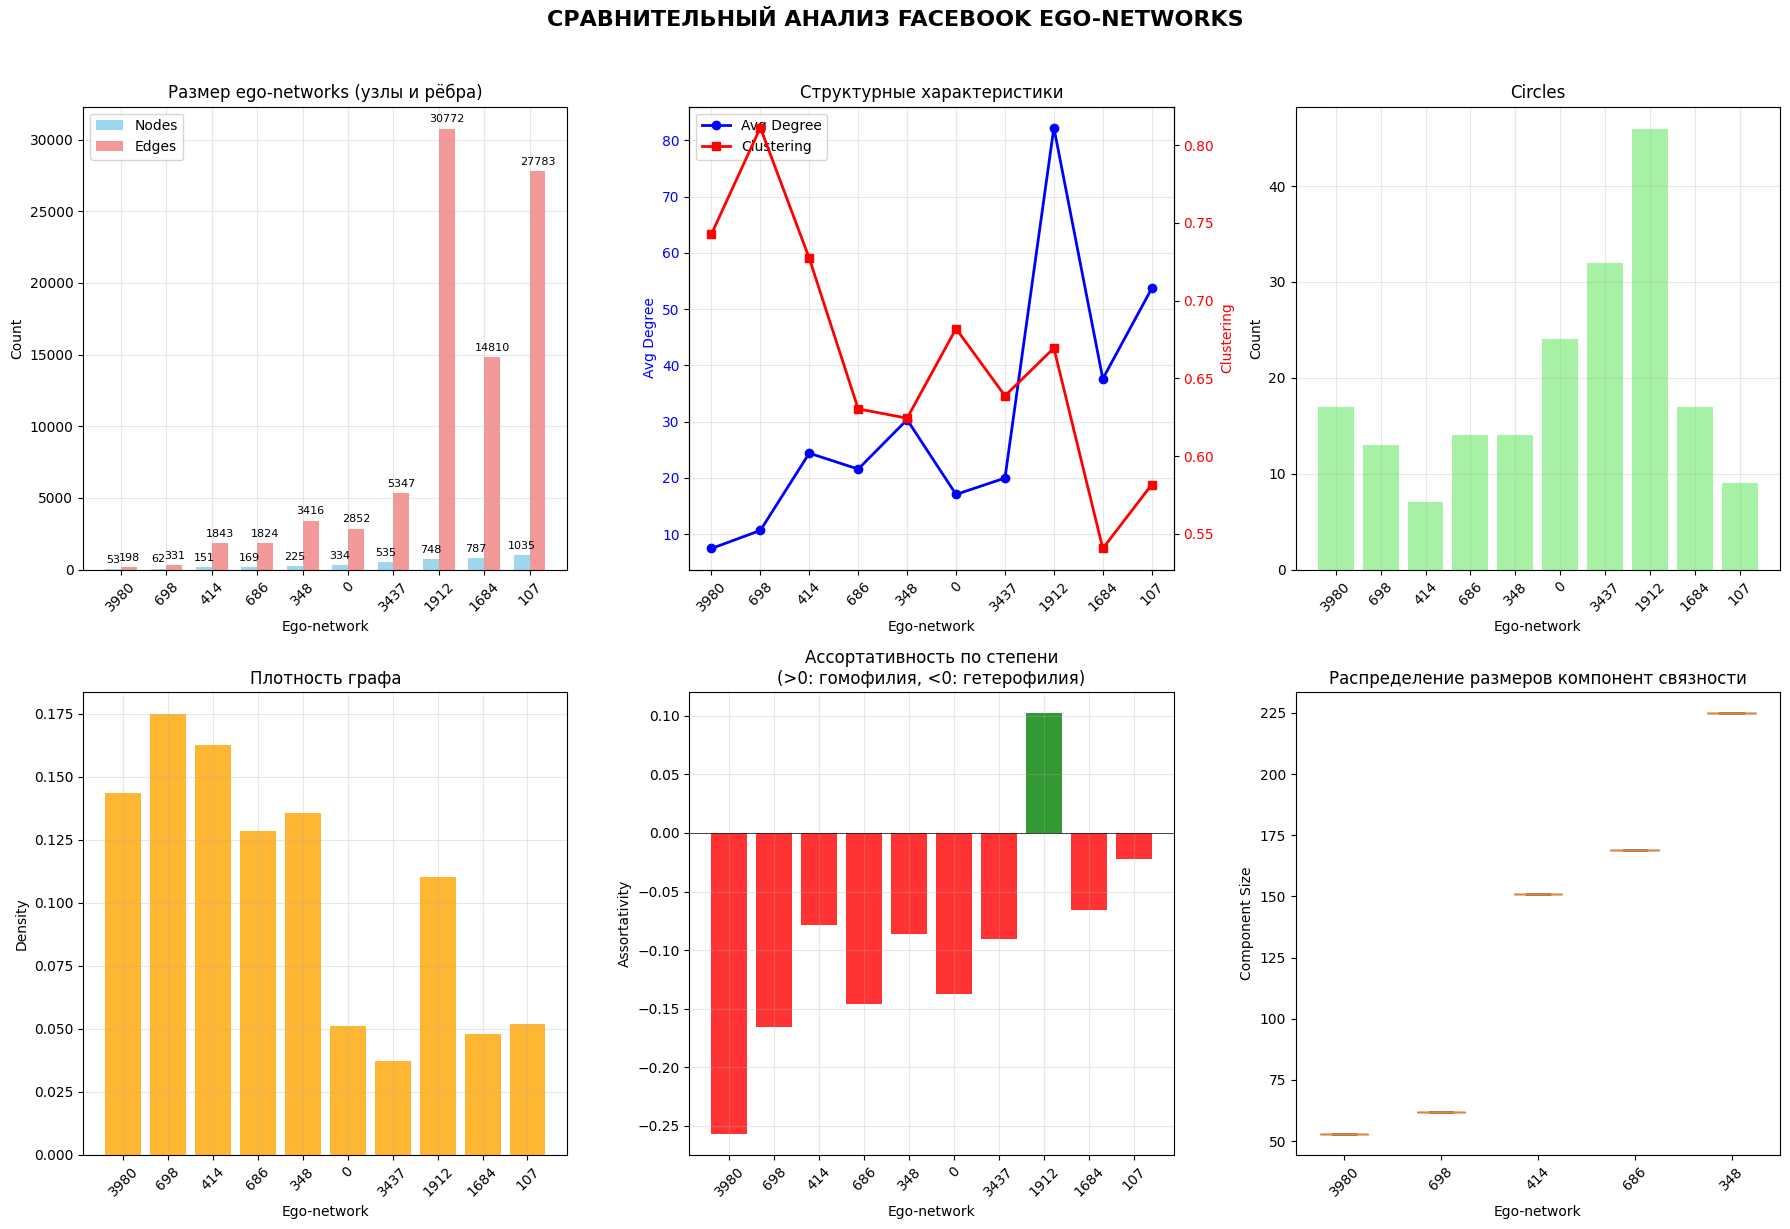

In [13]:
metrics_df = visualize_comparative_analysis(analysis_results)

### Выводы:
1. Все ego-networks показали высокий коэффициент кластеризации (0.54-0.81). Вероятно, данный подтверждает гипотезу транзитивности — друзья одного человека с большой вероятностью дружат между собой
2. Ассортативность по степени в основном отрицательная (8 из 10), что типично для звездообразных структур (тем более что рассматриваются отдельные ego-netwirks с выраженным центром).
3. Все сети имеют 1 компоненту связности, т.е. сети связныеи в них нет разрыва

## 2.2. Визуализация всего графа

In [14]:
def visualize_full_graph(G):
   
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    fig.suptitle('Анализ графа Facebook', fontsize=16, fontweight='bold')

    ax1 = axes[0, 0]
    ax1.set_title('Структура')
    pos = nx.spring_layout(G, k=2/np.sqrt(len(G.nodes())), iterations=50, seed=42)
    nx.draw_networkx_nodes(G, pos, ax=ax1, node_size=20, node_color='lightblue', alpha=0.7)
    nx.draw_networkx_edges(G, pos, ax=ax1, alpha=0.1, width=0.5)
    ax1.axis('off')

    ax2 = axes[0, 1]
    ax2.set_title('Распределение степеней узлов')
    
    degrees = [deg for _, deg in G.degree()]
    ax2.hist(degrees, bins=50, alpha=0.7, color='skyblue', edgecolor='black')
    ax2.set_xlabel('Степень узла')
    ax2.set_ylabel('Частота')
    ax2.grid(True, alpha=0.3)
    ax2.set_yscale('log')
    
    ax3 = axes[1, 0]
    ax3.set_title('Центральность узлов')
    
    degrees = dict(G.degree())
    
    deg_values = list(degrees.values())
    node_sizes = [50 + 500 * (deg - min(deg_values)) / (max(deg_values) - min(deg_values)) 
                 if max(deg_values) > min(deg_values) else 100 for deg in deg_values]
    
    norm = Normalize(vmin=min(deg_values), vmax=max(deg_values))
    cmap = cm.viridis
    node_colors = [cmap(norm(deg)) for _, deg in degrees.items()]
    
    nx.draw_networkx_nodes(G, pos, ax=ax3, node_size=node_sizes, node_color=node_colors, alpha=0.8)
    nx.draw_networkx_edges(G, pos, ax=ax3, alpha=0.05, width=0.3)
    ax3.axis('off')
    
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax3, shrink=0.8)
    cbar.set_label('Степень узла')

    # Здесь использую алгоритм Лувена (Louvain) для выделения сообществ 
    # https://habr.com/ru/companies/ecom_tech/articles/894982
    # https://louvain-igraph.readthedocs.io/en/latest/reference.html
    ax4 = axes[1, 1]
    ax4.set_title('Сообщества по Лувену')
    partition = community_louvain.best_partition(G)    

    communities = list(set(partition.values()))
    cmap_communities = cm.get_cmap('tab20', len(communities))
    community_colors = {com: cmap_communities(i) for i, com in enumerate(communities)}
    node_colors_community = [community_colors[partition[node]] for node in G.nodes()]
    
    nx.draw_networkx_nodes(G, pos, ax=ax4, node_size=30, node_color=node_colors_community, alpha=0.8)
    nx.draw_networkx_edges(G, pos, ax=ax4, alpha=0.05, width=0.3)
    # нашлось 
    legend_elements = [Patch(facecolor=community_colors[com], label=f'Сообщество {com} ({list(partition.values()).count(com)} узлов)')
                      for com in list(communities)]
    
    ax4.legend(handles=legend_elements, loc='upper right', fontsize=8)     
    ax4.axis('off')    
    plt.tight_layout()
    plt.show()
    

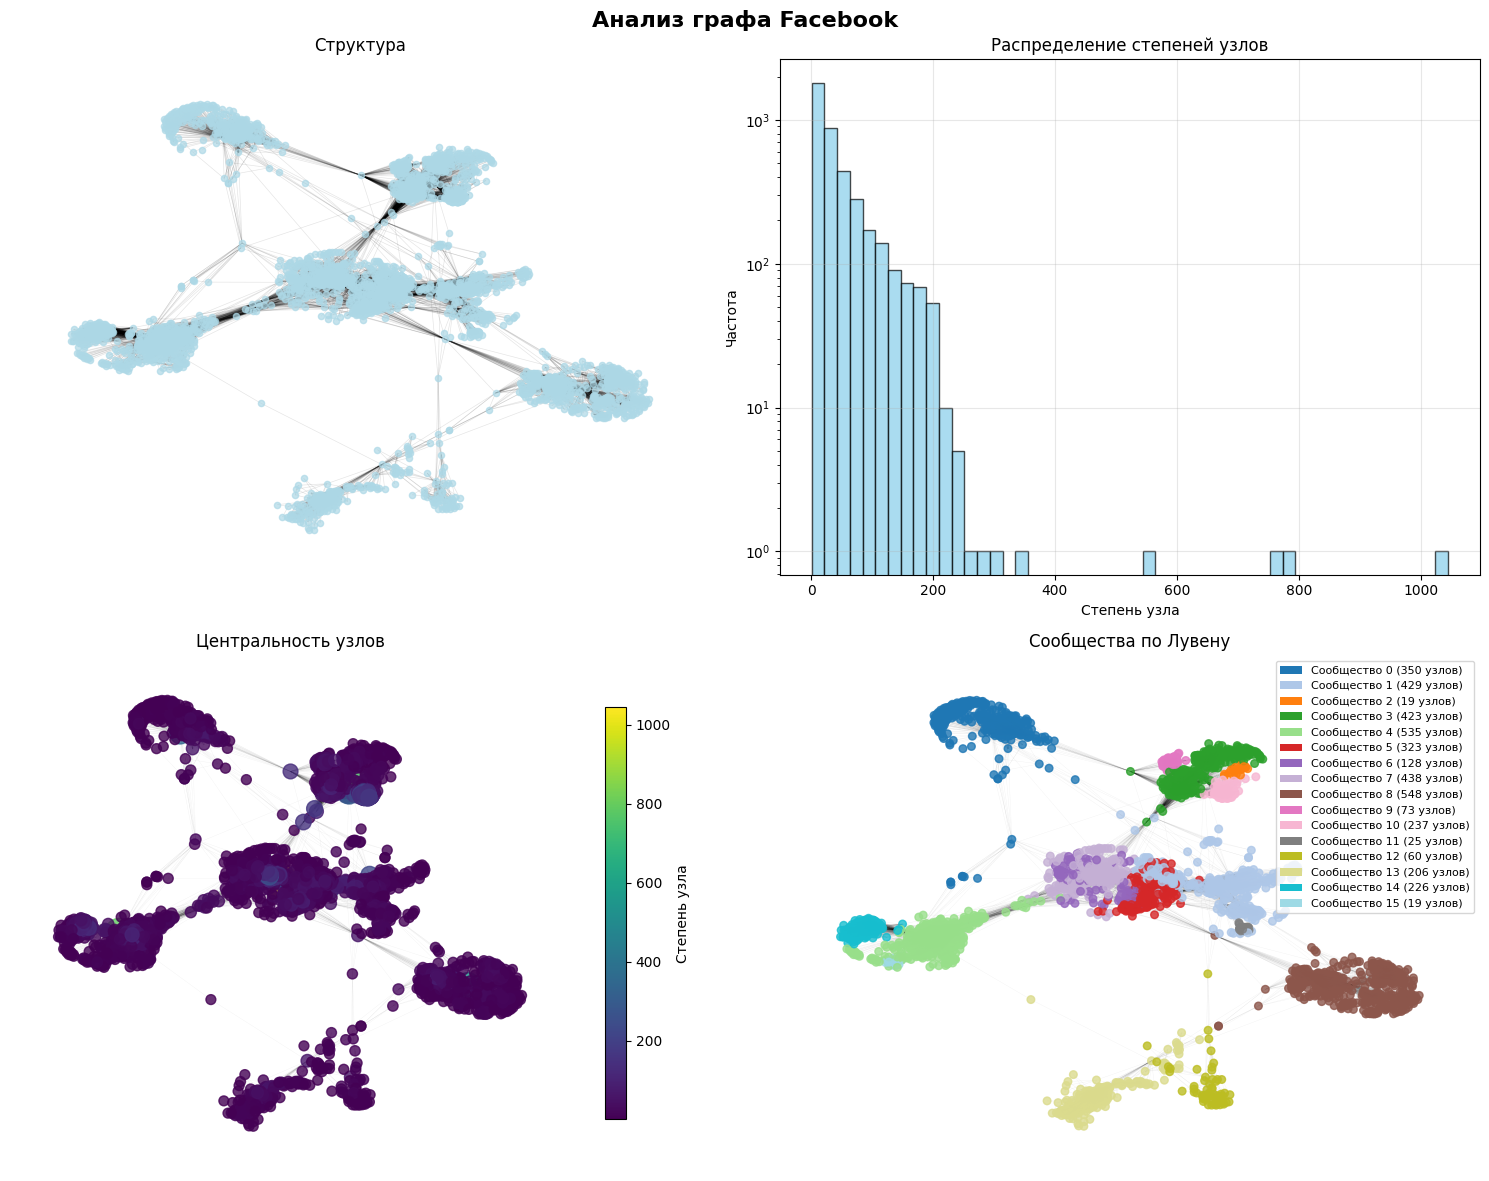

In [15]:
visualize_full_graph(G_combined)

### Выводы по визуализации
1. Структура графа (рис. 1): ярко выделены 5 крупных кластеров (облаков точек) и ещё 2 более мелких, но отдельных. Также на структуре выделяются узлы-брокеры (посредники) соединяющие между собой крупные кластеры.
2. Из 4039 узлов (рис. 2) только 26 имеют стеепень более 200 (местные "звёзды"). Они являются центральными в своих локальных сообществах (на рис. 3 выделены в желто-зелёном спектре). При этом больше половины узлов имеют степень менее 60, что указывает на среднестатистического пользователя Facebook или соцсетей в целом.
3. Алгоритм Лувена (рис. 4) выделил 14 сообществ, при этом были разделены даже те, которые визуально (рис.1) выглядят "монолитно". Наличие большего числа сообществ по сравнению с визуально наблюдаемыми кластерами (рис. 1) может указывать на наличие вложенных структур внутри крупных кластеров (например, различные социальные круги), либо же на несоответсвие геометрической близости на визуализации spring layout (рис. 1) и реальной плотностью связей

# 2. Топологический анализ

### Стратегия:

* Построение комплекса Виеториса-Рипса (VR-комплекс)  
* Построение персистентных диаграмм  
* Извлечение топологических инвариантов  
* Использовать TDA фичи для анализа классификации пользовательских кругов (circles)

**Ключевое наблюдение при проведениее TDA на графе (структурный TDA):**
мера расстояние "кратчайший путь" не сработала, поскольку все узлы на расстоянии 1 или 2 от ego (получилась буквально бинарная метрика), поэтому нет топологической структуры и отсутствовали циклы H1. Вместо этого использована альтернативная метрика - рассстояние Жаккара (Jaccard), учитывающая сходство окружения (общих друзей) для узла. Расстояние между узлами *u* и *v* рассчитывалось как 


$$jaccard(u, v) = 1 - \frac{|neighbors(u) ∩ neighbors(v)|} {|neighbors(u) ∪ neighbors(v)|}$$

Такая метрика дает непрерывные значения в отрезке [0, 1]. Поскольку цель проведения TDA - обнаружение структурных сообществ, то в данном случае используется обоснование:
`Сообщество = группа с общими друзьями`

### Функции для работы

In [8]:
def build_VR (dist_matrix, max_edge_len):
    try:        
        rips = gd.RipsComplex(distance_matrix = dist_matrix, max_edge_length=max_edge_len)        
        simplex_tree = rips.create_simplex_tree(max_dimension=2)
        persistence = simplex_tree.persistence(min_persistence=0.001)  
        
        return rips, simplex_tree, persistence          
    except Exception as e:
        print(f"  Ошибка построения VR: {e}")


In [9]:
def compute_PD(simplex_tree):
    persistence = simplex_tree.persistence()

    persistence_by_dim = {}
    for dim in range(3):  
        persistence_by_dim[dim] = [
            (birth, death) for (d, (birth, death)) in persistence 
            if d == dim and death != float('inf')  
        ]
    
    print(f"  H0 (компоненты): {len(persistence_by_dim[0])} точек")
    print(f"  H1 (циклы): {len(persistence_by_dim[1])} точек")
    print(f"  H2 (полости): {len(persistence_by_dim[2])} точек")
    
    return persistence_by_dim

In [10]:
def visualize_PD (persistence_by_dim, title="Персистентные диаграммы"):

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    dimensions = ['H0 (компоненты)', 'H1 (циклы)', 'H2 (полости)']
    colors = ['blue', 'red', 'green']
    
    for dim, (ax, dim_name, color) in enumerate(zip(axes, dimensions, colors)):
        points = persistence_by_dim[dim]
        
        if points:
            births = [p[0] for p in points]
            deaths = [p[1] for p in points]
            
            ax.scatter(births, deaths, alpha=0.6, color=color, s=30)
            
            # Диагональ (birth = death)
            max_val = max(max(births + deaths), 1.0) if births else 1.0
            ax.plot([0, max_val], [0, max_val], 'k--', alpha=0.3, linewidth=1)
            
            stable_points = sum(1 for b, d in points if (d - b) > max_val * 0.1)
            ax.set_title(f"{dim_name}\n{len(points)} точек, {stable_points} устойчивых")
        
        ax.set_xlabel('Birth')
        ax.set_ylabel('Death' if dim == 0 else '')
        ax.grid(True, alpha=0.3)
        ax.set_aspect('equal', adjustable='box')
    
    plt.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.savefig(f'tda_diagrams/EGO-{ego_id} {title}.png', dpi=150, bbox_inches='tight')
    plt.show()

In [11]:
def extract_topoinvariants(persistence_by_dim, distance_matrix=None, G=None):
    invariants = {}
    
    # Числа Бетти 
    for dim in [0, 1, 2]:
        points = persistence_by_dim.get(dim, [])
        invariants[f'betti_{dim}'] = len(points)
        
        if points:
            births = np.array([p[0] for p in points])
            deaths = np.array([p[1] for p in points])
            lifetimes = deaths - births
            
            # Персистентная статистика
            invariants[f'dim{dim}_total_persistence'] = float(np.sum(lifetimes))
            invariants[f'dim{dim}_mean_lifetime'] = float(np.mean(lifetimes))
            invariants[f'dim{dim}_max_lifetime'] = float(np.max(lifetimes))
            
            # Персистентная энтропия
            if len(lifetimes) > 1:
                normalized = lifetimes / np.sum(lifetimes)
                entropy = -np.sum(normalized * np.log(normalized + 1e-10))
                invariants[f'dim{dim}_entropy'] = float(entropy)
            
            # Birth/Death
            invariants[f'dim{dim}_mean_birth'] = float(np.mean(births))
            invariants[f'dim{dim}_mean_death'] = float(np.mean(deaths))
    
    # Ранги персистентности
    if persistence_by_dim.get(1):
        lifetimes_h1 = [d - b for b, d in persistence_by_dim[1]]
        thresholds = [0.01, 0.05, 0.1, 0.2]
        for t in thresholds:
            invariants[f'h1_persistent_above_{t}'] = sum(1 for lt in lifetimes_h1 if lt > t)
    
    # Инварианты графа
    if G is not None:
        invariants.update({
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'clustering': nx.average_clustering(G),
            'assortativity': nx.degree_assortativity_coefficient(G),
            'diameter': nx.diameter(G) if nx.is_connected(G) else None,
            'density': nx.density(G)
        })
    
    # Мнварианты матрицы расстояния
    if distance_matrix is not None:
        non_zero = distance_matrix[distance_matrix > 0]
        if len(non_zero) > 0:
            invariants.update({
                'mean_distance': float(np.mean(non_zero)),
                'distance_std': float(np.std(non_zero)),
                'distance_90_percentile': float(np.percentile(non_zero, 90))
            })
    
    return invariants



## TDA pipeline

In [12]:
def tda_pipeline(ego_data, ego_id=None):
    
    print("="*70)
    print(f"TDA analysis for ego-network {ego_id}")
    print("="*70)
    
    G = ego_data['graph']
    circles = ego_data.get('circles', {})
    node_features = ego_data.get('node_features', None)
    
    results = {
        'ego_id': ego_id,
        'graph_info': {
            'num_nodes': G.number_of_nodes(),
            'num_edges': G.number_of_edges(),
            'clustering': nx.average_clustering(G),
            'assortativity': nx.degree_assortativity_coefficient(G),
            'max_distance': 2  
        }
    }
    
    # Расстояние Жаккара - работает, кратчайшие пути - нет

    print("\n1. TDA на графе (структурная топология):")
    
    try:
        n_nodes = G.number_of_nodes()
        node_list = list(G.nodes())
        jaccard_matrix = np.zeros((n_nodes, n_nodes))
        
        for i in range(n_nodes):
            neighbors_i = set(G.neighbors(node_list[i]))
            for j in range(i+1, n_nodes):
                neighbors_j = set(G.neighbors(node_list[j]))
                
                if neighbors_i or neighbors_j:
                    intersection = len(neighbors_i & neighbors_j)
                    union = len(neighbors_i | neighbors_j)
                    similarity = intersection / union if union > 0 else 0
                    distance = 1 - similarity
                else:
                    distance = 1.0
                
                jaccard_matrix[i, j] = distance
                jaccard_matrix[j, i] = distance

                
        rips, simplex_tree, persistence = build_VR(jaccard_matrix, 0.8)
        
        persistence_dict = {0: [], 1: [], 2: []}
        h1_points = []
        
        for dim, (birth, death) in persistence:
            if dim in persistence_dict and death != float('inf'):
                persistence_dict[dim].append((birth, death))
                if dim == 1:
                    h1_points.append((birth, death))
        
        counts = {dim: len(points) for dim, points in persistence_dict.items()}
                
        print(f"  H0: {counts[0]}, H1: {counts[1]}, H2: {counts[2]}")
        
        if h1_points:
            lifetimes = [d - b for b, d in h1_points]
            
            print(f"  Среднее время жизни: {np.mean(lifetimes):.4f}")
            print(f"  Максимальное время жизни: {np.max(lifetimes):.4f}")
            
            persistence_by_dim = {}
            for dim in [0, 1, 2]:
                persistence_by_dim[dim] = [(birth, death) for (d, (birth, death)) in persistence 
                                           if d == dim and death != float('inf')]
            
            visualize_PD(persistence_by_dim, title=f"Graph Persistance Diagramm")
   
        
        results['graph_tda'] = {
            'metric': 'jaccard',
            'distance_matrix': jaccard_matrix,
            'persistence': persistence_dict,
            'counts': counts,
            'h1_points': h1_points,
            'h1_count': len(h1_points)
        }
        
    except Exception as e:
        print(f"  Ошибка: {e}")
    

    if node_features is not None:
        print("\n2. TDA на эмбеддингах (семантическая топология):")      
        try:
            # Подготовка эмбеддингов
            feat_node_ids = ego_data.get('node_ids', [])
            if len(feat_node_ids) > 0:
                node_to_feat_idx = {node_id: i for i, node_id in enumerate(feat_node_ids)}
                graph_nodes = sorted(list(G.nodes()))
                
                embeddings_list = []
                for node in graph_nodes:
                    if node in node_to_feat_idx:
                        embeddings_list.append(node_features[node_to_feat_idx[node]])
                    else:
                        embeddings_list.append(np.zeros(node_features.shape[1]))
                
                embeddings = np.array(embeddings_list)

                distance_matrix = euclidean_distances(embeddings)
                non_zero_dists = distance_matrix[distance_matrix > 0]
                
                if len(non_zero_dists) > 0:
                    max_edge_length = np.percentile(non_zero_dists, 85)
                else:
                    max_edge_length = 5.0


                rips_emb, simplex_tree_emb, persistence_emb = build_VR(distance_matrix,max_edge_length)

                persistence_dict_emb = {0: [], 1: [], 2: []}
                h1_points_emb = []
                
                for dim, (birth, death) in persistence_emb:
                    if dim in persistence_dict_emb and death != float('inf'):
                        persistence_dict_emb[dim].append((birth, death))
                        if dim == 1:
                            h1_points_emb.append((birth, death))
                
                counts_emb = {dim: len(points) for dim, points in persistence_dict_emb.items()}
                
                print(f"  H0: {counts_emb[0]}, H1: {counts_emb[1]}, H2: {counts_emb[2]}")
                
                if h1_points_emb:
                    lifetimes = [d - b for b, d in h1_points_emb]
                    print(f"  Среднее время жизни циклов: {np.mean(lifetimes):.4f}")
                    print(f"  Максимальное время жизни: {np.max(lifetimes):.4f}")

                for dim in [0, 1, 2]:
                    persistence_by_dim[dim] = [(birth, death) for (d, (birth, death)) in persistence_emb 
                                               if d == dim and death != float('inf')]
                visualize_PD(persistence_by_dim, title=f"Embedding Persistance Diagramm")
                
                results['embedding_tda'] = {
                    'distance_matrix': distance_matrix,
                    'persistence': persistence_dict_emb,  
                    'h1_points': h1_points_emb,
                    'embeddings': embeddings
                }
        
        except Exception as e:
            print(f"  Ошибка: {e}")
    

    print("\n3. Извлечение топо-фичей:")
    
    try:
        if 'graph_tda' in results:
            jaccard_matrix = results['graph_tda']['distance_matrix']
            n_nodes = jaccard_matrix.shape[0]
            
            node_features_topo = []
            
            for i in range(n_nodes):
                features = []               

                jaccard_dists = jaccard_matrix[i]
                
                features.append(np.mean(jaccard_dists[jaccard_dists > 0]))
                features.append(np.min(jaccard_dists[jaccard_dists > 0]))                
                features.append(np.std(jaccard_dists[jaccard_dists > 0]))
                
                close_neighbors = np.sum(jaccard_dists < 0.5)
                features.append(close_neighbors)
                
                node_features_topo.append(features)
            
            topo_features = np.array(node_features_topo)
            
            results['topological_features'] = {
                'jaccard_based': topo_features,
                'node_ids': sorted(list(G.nodes())),
                'feature_names': [
                    'mean_jaccard_distance',
                    'min_jaccard_distance', 
                    'std_jaccard_distance',
                    'close_neighbors_count'
                ]
            }
            
            print(f"  Извлечено признаков: {topo_features.shape}")
            print(f"  Пример признаков узла 0: {topo_features[0]}")
    
    except Exception as e:
        print(f"  Ошибка: {e}")
        results['topological_features'] = {}
    


    print("\n4. Извлечение топологических инвариантов:")
    
    # Инварианты графа
    if 'graph_tda' in results and 'persistence' in results['graph_tda']:
       
        persistence_by_dim = results['graph_tda']['persistence']         
        
        graph_invariants = extract_topoinvariants(persistence_by_dim, results['graph_tda'].get('distance_matrix'), G)              
        results['graph_tda']['invariants'] = graph_invariants
        
        print(f"\n  Инварианты графа:")
        for key, value in graph_invariants.items():
            print(f"    {key}: {value}")

       
    # Инварианты эмбеддингов
    if 'embedding_tda' in results and 'persistence' in results['embedding_tda']:
        persistence_by_dim_emb = results['embedding_tda']['persistence']          
        emb_invariants = extract_topoinvariants(persistence_by_dim_emb, results['embedding_tda'].get('distance_matrix'))
        
        results['embedding_tda']['invariants'] = emb_invariants        
        print(f"\n  Инварианты эмбеддингов:")

        for key, value in emb_invariants.items():
            print(f"    {key}: {value}")       
    
    if circles and 'topological_features' in results:
        print("\n5. Сравнение с пользовательскими кругами:")
        
        # Гипотеза 1: Круги ≈ структурные сообщества в графе
        
        print("\n  5.1. Структурная топология vs круги:")
        
        try:
            structural_features = results['topological_features']['jaccard_based']
            node_ids = results['topological_features']['node_ids']
            
            labels = np.zeros(len(node_ids))
            node_to_idx = {node_id: i for i, node_id in enumerate(node_ids)}
            
            for circle_idx, (circle_name, members) in enumerate(circles.items()):
                for member in members:
                    if member in node_to_idx:
                        labels[node_to_idx[member]] = circle_idx + 1

            mask = labels > 0
            if np.sum(mask) > 1 and len(np.unique(labels[mask])) > 1:
                silhouette_structural = silhouette_score(structural_features[mask], labels[mask].astype(int))                            
                print(f"    Силуэтный коэффициент (структурный): {silhouette_structural:.3f}")
                
                if silhouette_structural > 0.3:
                    print(f"    Круги соответствуют структурным сообществам")
                elif silhouette_structural > 0:
                    print(f"    Слабая структурная корреляция")
                else:
                    print(f"    Круги НЕ соответствуют структурным сообществам")
        
        except Exception as e:
            print(f"    Ошибка структурного сравнения: {e}")
        

        # Гипотеза 2: Круги ≈ семантические кластеры в пространстве признаков

        if 'embedding_tda' in results and 'embeddings' in results['embedding_tda']:
            print("\n  5.2. Семантическая топология vs круги:")
            
            try:
                embeddings = results['embedding_tda']['embeddings']  # (334, 224)
                
                if 'node_ids' in results['topological_features']:
                    node_ids = results['topological_features']['node_ids']
                    labels = np.zeros(len(node_ids))
                    node_to_idx = {node_id: i for i, node_id in enumerate(node_ids)}
                    
                    for circle_idx, (circle_name, members) in enumerate(circles.items()):
                        for member in members:
                            if member in node_to_idx:
                                labels[node_to_idx[member]] = circle_idx + 1
                    
                    mask = labels > 0
                    if np.sum(mask) > 1 and len(np.unique(labels[mask])) > 1:
                        silhouette_semantic = silhouette_score(embeddings[mask], labels[mask].astype(int))                                          
                        print(f"    Силуэтный коэффициент (семантический): {silhouette_semantic:.3f}")

                        if silhouette_semantic > 0.3:
                            print(f"    Круги соответствуют семантическим кластерам")
                        elif silhouette_semantic > 0:
                            print(f"    Слабая семантическая корреляция")
                        else:
                            print(f"    Круги НЕ соответствуют семантическим кластерам")
                
                            
            except Exception as e:
                print(f"    Ошибка семантического сравнения: {e}")
        

        print("\n  5.3. Визуализация сравнений:")
        
        try:
            if 'topological_features' in results and 'embedding_tda' in results:
                fig, axes = plt.subplots(2, 2, figsize=(15, 12))

                structural_features = results['topological_features']['jaccard_based']
                embeddings = results['embedding_tda']['embeddings']
                node_ids = results['topological_features']['node_ids']

                labels = np.zeros(len(node_ids))
                node_to_idx = {node_id: i for i, node_id in enumerate(node_ids)}
                
                for circle_idx, (circle_name, members) in enumerate(circles.items()):
                    for member in members:
                        if member in node_to_idx:
                            labels[node_to_idx[member]] = circle_idx + 1
                
                ax = axes[0, 0]
                if structural_features.shape[1] >= 2:
                    scatter = ax.scatter(
                        structural_features[:, 0], 
                        structural_features[:, 1], 
                        c=labels, cmap='tab20', alpha=0.7, s=30
                    )
                    ax.set_xlabel('Mean Jaccard distance')
                    ax.set_ylabel('Min Jaccard distance')
                    ax.set_title('Structural features VS circles')
                    plt.colorbar(scatter, ax=ax, label='Circles')

                ax = axes[0, 1]
                if embeddings.shape[1] >= 2:
                    
                    # PCA для визуализации                    
                    if embeddings.shape[1] > 2:
                        pca = PCA(n_components=2)
                        embeddings_2d = pca.fit_transform(embeddings)
                    else:
                        embeddings_2d = embeddings
                    
                    scatter = ax.scatter(
                        embeddings_2d[:, 0], 
                        embeddings_2d[:, 1], 
                        c=labels, cmap='tab20', alpha=0.7, s=30
                    )
                    ax.set_xlabel('PC1')
                    ax.set_ylabel('PC2')
                    ax.set_title('Semantic features VS circles')
                    plt.colorbar(scatter, ax=ax, label='Circles')
                

                ax = axes[1, 0]
                comparison_data = []

                if 'silhouette_structural' in locals():
                    comparison_data.append(('Структурный', silhouette_structural))
                
                if 'silhouette_semantic' in locals():
                    comparison_data.append(('Семантический', silhouette_semantic))
                
                if comparison_data:
                    names, values = zip(*comparison_data)
                    colors = ['skyblue' if v > 0 else 'lightcoral' for v in values]
                    bars = ax.bar(names, values, color=colors, alpha=0.7)
                    
                    ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
                    ax.axhline(y=0.3, color='green', linestyle='--', alpha=0.5, 
                              label='Хорошая кластеризация (0.3)')
                    ax.set_ylabel('Silhouette')
                    ax.set_title('Сравнение качества кластеризации кругов')
                    ax.legend()
                    
                    for bar, val in zip(bars, values):
                        height = bar.get_height()
                        ax.text(bar.get_x() + bar.get_width()/2., height, f'{val:.3f}', ha='center', va='bottom')
                        
                ax = axes[1, 1]
                circle_stats = []
                circle_names = []
                
                for circle_name, members in circles.items():
                    member_indices = [node_to_idx[m] for m in members if m in node_to_idx]
                    if member_indices:

                        if structural_features.shape[1] > 0:
                            circle_features = structural_features[member_indices]
                            avg_similarity = 1 - np.mean(circle_features[:, 0])  
                            circle_stats.append(avg_similarity)
                            circle_names.append(circle_name[:10]) 
            
                if circle_stats:
                    bars = ax.bar(range(len(circle_stats)), circle_stats, alpha=0.7)
                    ax.set_xlabel('Circles')
                    ax.set_ylabel('Средняя структурная схожесть')
                    ax.set_title('Структурная сплоченность кругов')
                    ax.set_xticks(range(len(circle_names)))
                    ax.set_xticklabels(circle_names, rotation=45, ha='right', fontsize=8)
                
                plt.tight_layout()
                plt.savefig(f'tda_diagrams/EGO-{ego_id} Circles Comparison.png', dpi=150, bbox_inches='tight')
                plt.show()
        
        except Exception as e:
            print(f"    Ошибка визуализации: {e}")
        
    return results

### Запуск

TDA analysis for ego-network 3437

1. TDA на графе (структурная топология):
  H0: 526, H1: 146, H2: 0
  Среднее время жизни: 0.0317
  Максимальное время жизни: 0.1494


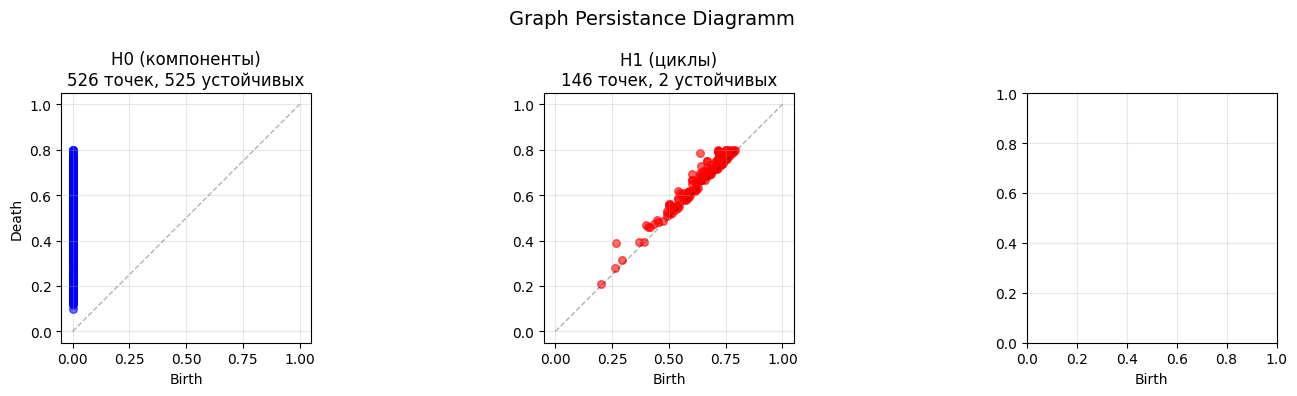


2. TDA на эмбеддингах (семантическая топология):
  H0: 401, H1: 43, H2: 0
  Среднее время жизни циклов: 0.2613
  Максимальное время жизни: 0.4495


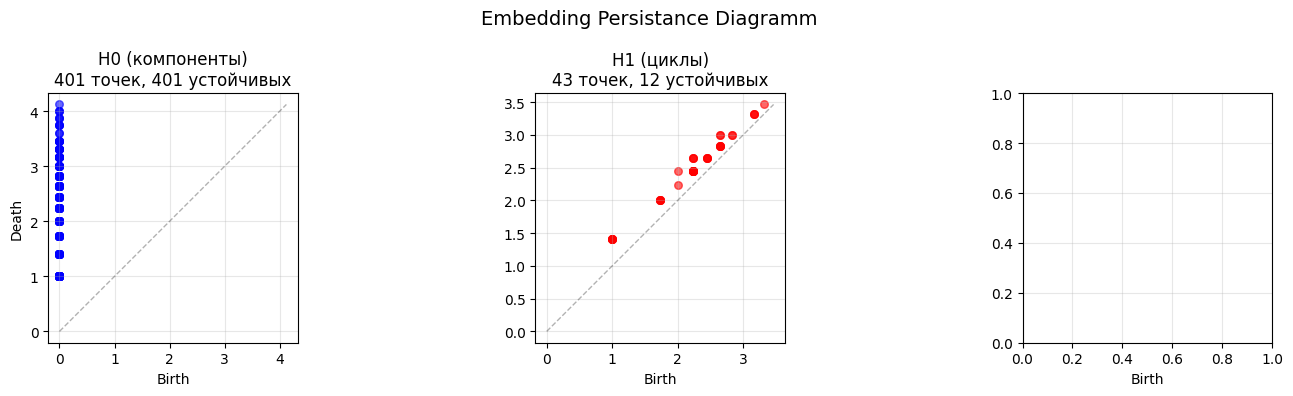


3. Извлечение топо-фичей:
  Извлечено признаков: (535, 4)
  Пример признаков узла 0: [0.95572306 0.71794872 0.04465706 1.        ]

4. Извлечение топологических инвариантов:

  Инварианты графа:
    betti_0: 526
    dim0_total_persistence: 266.4889585534315
    dim0_mean_lifetime: 0.5066330010521511
    dim0_max_lifetime: 0.8
    dim0_entropy: 6.203840561581414
    dim0_mean_birth: 0.0
    dim0_mean_death: 0.5066330010521511
    betti_1: 146
    dim1_total_persistence: 4.624751465613971
    dim1_mean_lifetime: 0.03167637990146556
    dim1_max_lifetime: 0.14935064935064934
    dim1_entropy: 4.6895287594211315
    dim1_mean_birth: 0.6342211331184772
    dim1_mean_death: 0.6658975130199428
    betti_2: 0
    h1_persistent_above_0.01: 115
    h1_persistent_above_0.05: 33
    h1_persistent_above_0.1: 2
    h1_persistent_above_0.2: 0
    num_nodes: 535
    num_edges: 5347
    clustering: 0.6388072137858635
    assortativity: -0.09086539663576841
    diameter: 2
    density: 0.03743218173544

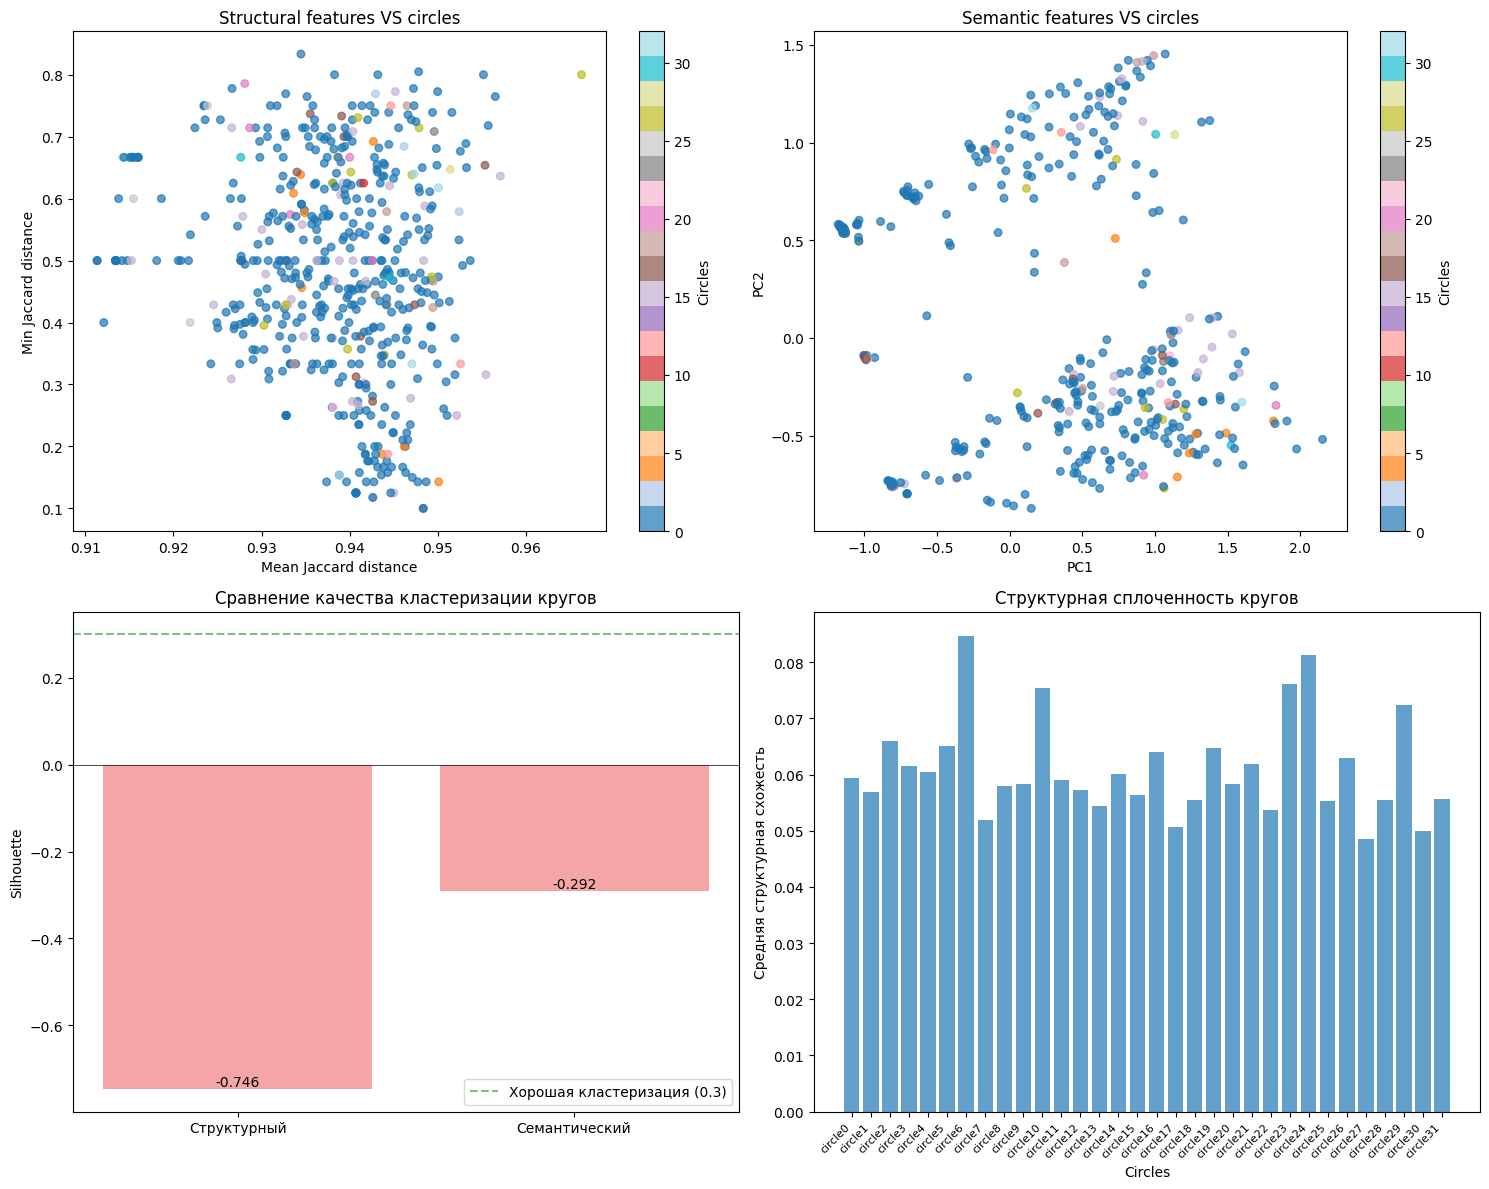


Summary for ego 3437:
  Узлов: 535
  Рёбер: 5347
  Коэффициент кластеризации: 0.639
  Найдено циклов H1: 146
  Извлечено топологических фичей: (535, 4)

TDA анализ завершен успешно!


In [13]:
ego_id='3437'
results_tda = tda_pipeline(ego_networks[ego_id], ego_id)

if results_tda:
    # Сводка результатов
    print(f"\nSummary for ego {ego_id}:")
    print(f"  Узлов: {results_tda['graph_info']['num_nodes']}")
    print(f"  Рёбер: {results_tda['graph_info']['num_edges']}")
    print(f"  Коэффициент кластеризации: {results_tda['graph_info']['clustering']:.3f}")
    
    if 'graph_tda' in results_tda:
        print(f"  Найдено циклов H1: {results_tda['graph_tda']['h1_count']}")
    
    if 'topological_features' in results_tda:
        shape = results_tda['topological_features']['jaccard_based'].shape
        print(f"  Извлечено топологических фичей: {shape}")
    
    print(f"\nTDA анализ завершен успешно!")
    
else:
    print(f"\nTDA успешно провален!")

## Результаты TDA для ego-network:
Я не стал визуализировать результаты для всех 10 ego-network, а оставил только 1, но выводы будут по всем 10 полученным результатам.
1. Вместо исходной гипотезы "пользовательские круги соответствуют геометрическим\семантическим кластерам" получилось ровно наоборот - ни в одной из ego-network круги не соответствуют ни семантическим, ни структурным кластерам. Результат основан на силуэтном коэффициенте, который не превысил -0.02 (это был самый максимальный результат) - т.е. узлы внутри одного круга в среднем больше похожи на узлы из других, чем на свои
2. Пользователи размечают круги по разным критериям, участники которых, зачастую, вообще не похожи между собой (например "коллеги", "соседи", "школьные знакомые" и пр). Их объединяет география, время, эмоции, интересы, а не наличие связей с остальными участниками ego-network, что выражено в низком времени жизни структурных циклов H1
3. Время жизни семантических циклов H1 всегда больше структурных, что подтверждает гипотезу об объединении пользовательских кругов по принципу эмоций или интересов - такие циклы являются более значимыми топологическими фичами
4. Поскольку количество семантических циклов всегда меньше структурых, это говорит о том, что его друзья, будучи сильно связаны структурно, образуют несколько более чётких и устойчивых семантических групп. Возможно, эти семантические кластеры могли бы стать более естественным разделением ego-network на круги, чем те, которые пользователь задал сам.
5. Низкая структурная сплочённость внутри кругов - в среднем 8% (последний график), говорящая о том, насколько пользователи из круга похожи в социальном смысле. Фактически если у ego 100 друзей, то с другими членами из круга у него в среднем всего 8 общих друзей. Это также согласуется с низким силуэтным коэффициентом и подтверждает вывод, что **пользовательские круги — субъективные социальные группы**
6. **Социальная реальность сложнее математических моделей**

---
## Полученные результаты анализа отдельных ego-network не совсем согласуются с геометрическими prior'ами:

### Prior 1: Гомофилия (сходство => связь)
- **Метрика**: Силуэтный коэффициент семантических признаков
- **Результат**: везде отрицательный
- **Что значит**: Не подтверждена. Пользовательские круги не группируют похожих людей.

### Prior 2: Транзитивность (треугольные замыкания)  
- **Метрика**: Коэффициент кластеризации + циклы H1
- **Результат**: кластеризация в среднем 0.6 + везде образуются циклы H1 в количестве $$\frac{nodes}{3}$$
- **Что значит**: Подтверждена. Но время жизни циклов небольшое, что говорит о нестабильности групп.

### Prior 3: Ассортативность по степени
- **Метрика**: Коэффициент ассортативности
- **Результат**: везде отрицательный (кроме ego-network 1912)
- **Что значит**: Не подтверждена. Вместо этого — анти-ассортативность (звездообразность). Хотя это и согласуется с концепцией ego-network
  
---
**ВЫВОД:** необходимо провести TDA на всём графе для анализа формы и проверки геометрических prior'ов ___на всём графе___, а также извлечь ___глобальные топологические фичи___ для обогащения узлов.

In [46]:
def smart_node_sampling(G, strategy="degree_based", sample_size=500, random_state=42):
    """
    Умная выборка узлов для TDA, сохраняющая структуру графа
    
    Стратегии:
    - "degree_based": выбираем узлы с высокой степенью (хабы)
    - "community_cores": по 1 узлу из каждого крупного сообщества  
    - "random": случайная выборка (базовая)
    - "sparse_cover": узлы, максимально покрывающие граф
    """
    print(f"\nУмная выборка узлов (стратегия: {strategy}, n={sample_size})...")
    
    nodes = list(G.nodes())
    
    if strategy == "degree_based":
        # Выбираем узлы с наибольшей степенью (хабы)
        degrees = [(node, G.degree(node)) for node in nodes]
        degrees.sort(key=lambda x: x[1], reverse=True)
        sampled_nodes = [node for node, _ in degrees[:sample_size]]
        
    elif strategy == "community_cores":
        # Обнаружение сообществ и выбор центральных узлов
        try:
            import community as community_louvain
            partition = community_louvain.best_partition(G)
            
            # Группируем узлы по сообществам
            communities = {}
            for node, comm_id in partition.items():
                if comm_id not in communities:
                    communities[comm_id] = []
                communities[comm_id].append(node)
            
            # Выбираем узел с max степенью из каждого крупного сообщества
            sampled_nodes = []
            for comm_id, comm_nodes in communities.items():
                if len(comm_nodes) > 10:  # Только крупные сообщества
                    # Находим узел с максимальной степенью в сообществе
                    hub = max(comm_nodes, key=lambda x: G.degree(x))
                    sampled_nodes.append(hub)
            
            # Если не набрали достаточно, добавляем случайные
            if len(sampled_nodes) < sample_size:
                remaining = sample_size - len(sampled_nodes)
                other_nodes = [n for n in nodes if n not in sampled_nodes]
                sampled_nodes.extend(
                    np.random.choice(other_nodes, min(remaining, len(other_nodes)), replace=False)
                )
                
        except ImportError:
            print("  Модуль community не установлен, используем degree_based")
            return smart_node_sampling(G, "degree_based", sample_size, random_state)
    
    elif strategy == "sparse_cover":
        # Алгоритм покрытия графа: начинаем с случайного узла,
        # затем добавляем наиболее удалённые от уже выбранных
        np.random.seed(random_state)
        sampled_nodes = [np.random.choice(nodes)]
        
        # Матрица расстояний (вычисляем постепенно)
        for _ in range(1, sample_size):
            # Для каждого кандидата вычисляем минимальное расстояние до уже выбранных
            candidates = [n for n in nodes if n not in sampled_nodes]
            best_candidate = None
            max_min_distance = -1
            
            # Ограничим проверку для скорости
            for candidate in candidates[:1000]:
                min_dist = min(
                    nx.shortest_path_length(G, candidate, selected, cutoff=5)
                    for selected in sampled_nodes[:20]  # Проверяем только против первых 20
                )
                if min_dist > max_min_distance:
                    max_min_distance = min_dist
                    best_candidate = candidate
            
            if best_candidate:
                sampled_nodes.append(best_candidate)
            else:
                # Если не нашли, берём случайный
                remaining = [n for n in nodes if n not in sampled_nodes]
                sampled_nodes.append(np.random.choice(remaining))
    
    else:  # "random"
        np.random.seed(random_state)
        sampled_nodes = np.random.choice(nodes, min(sample_size, len(nodes)), replace=False)
    
    print(f"  Выбрано {len(sampled_nodes)} узлов")
    print(f"  Средняя степень в выборке: {np.mean([G.degree(n) for n in sampled_nodes]):.1f}")
    
    return list(sampled_nodes)


In [48]:
def compute_distance_matrix_for_sample(G, sampled_nodes):
    """
    Вычисление матрицы расстояний Жаккара ТОЛЬКО для выборки узлов
    """
    print(f"\nВычисление матрицы расстояний для {len(sampled_nodes)} узлов...")
    
    start_time = time.time()
    n = len(sampled_nodes)
    dist_matrix = np.zeros((n, n))
    
    # Предварительно вычисляем соседей для каждого узла в выборке
    neighbors_dict = {}
    for i, node in enumerate(sampled_nodes):
        neighbors_dict[i] = set(G.neighbors(node))
    
    # Вычисляем расстояние Жаккара для каждой пары в выборке
    for i in range(n):
        if i % 50 == 0 and i > 0:
            elapsed = time.time() - start_time
            remaining = (elapsed / (i+1)) * (n - i)
            print(f"  Обработано {i}/{n} узлов, осталось ~{remaining:.0f} сек")
        
        neighbors_i = neighbors_dict[i]
        
        for j in range(i+1, n):
            neighbors_j = neighbors_dict[j]
            
            if neighbors_i or neighbors_j:
                intersection = len(neighbors_i & neighbors_j)
                union = len(neighbors_i | neighbors_j)
                similarity = intersection / union if union > 0 else 0
                distance = 1 - similarity
            else:
                distance = 1.0
            
            dist_matrix[i, j] = distance
            dist_matrix[j, i] = distance
    
    elapsed_time = time.time() - start_time
    print(f"  Время вычисления: {elapsed_time:.2f} секунд")
    print(f"  Размер матрицы: {dist_matrix.shape}")
    print(f"  Диапазон расстояний: [{np.min(dist_matrix[dist_matrix>0]):.3f}, {np.max(dist_matrix):.3f}]")
    
    return dist_matrix

In [50]:
def compute_global_features_full_graph(G):
    """
    Вычисление глобальных признаков на ПОЛНОМ графе
    (это возможно и нужно делать!)
    """
    print("\n" + "="*60)
    print("ВЫЧИСЛЕНИЕ ГЛОБАЛЬНЫХ ПРИЗНАКОВ (ПОЛНЫЙ ГРАФ)")
    print("="*60)
    
    features = {}
    
    # 1. Базовые инварианты
    features['num_nodes'] = G.number_of_nodes()
    features['num_edges'] = G.number_of_edges()
    features['density'] = nx.density(G)
    features['avg_clustering'] = nx.average_clustering(G)
    
    # 2. Ассортативность
    try:
        features['degree_assortativity'] = nx.degree_assortativity_coefficient(G)
    except:
        features['degree_assortativity'] = 0
    
    # 3. Распределение степеней
    degrees = [d for _, d in G.degree()]
    features['degree_mean'] = np.mean(degrees)
    features['degree_std'] = np.std(degrees)
    features['degree_max'] = np.max(degrees)
    
    # 4. Центральности (вычисляем для ВСЕХ узлов - это критично!)
    print("  Вычисление центральностей для всех узлов...")
    
    # PageRank (быстрый алгоритм)
    features['pagerank'] = nx.pagerank(G, alpha=0.85)
    
    # Betweenness centrality с выборкой для ускорения
    k = min(1000, G.number_of_nodes())
    features['betweenness'] = nx.betweenness_centrality(G, k=k)
    
    # Degree centrality (просто нормированная степень)
    features['degree_centrality'] = nx.degree_centrality(G)
    
    # 5. Сообщества (Louvain) на полном графе
    print("  Обнаружение сообществ (Louvain)...")
    try:
        import community as community_louvain
        partition = community_louvain.best_partition(G)
        features['communities'] = partition
        features['num_communities'] = len(set(partition.values()))
        
        # Размеры сообществ
        comm_sizes = {}
        for node, comm_id in partition.items():
            comm_sizes[comm_id] = comm_sizes.get(comm_id, 0) + 1
        features['avg_community_size'] = np.mean(list(comm_sizes.values()))
        
    except ImportError:
        print("  Модуль community не установлен")
        features['communities'] = {node: 0 for node in G.nodes()}
        features['num_communities'] = 1
    
    # 6. Связность
    if nx.is_connected(G):
        features['diameter'] = nx.diameter(G)
        features['avg_path_length'] = nx.average_shortest_path_length(G)
    else:
        features['diameter'] = None
        features['avg_path_length'] = None
    
    print(f"  Вычислено {len(features)} глобальных признаков")
    
    return features

In [49]:
def tda_on_sample_with_global_context(G, sample_size=800, strategy="degree_based"):
    """
    Гибридный подход: TDA на выборке + глобальные фичи со всего графа
    """
    print("\n" + "="*80)
    print("ГИБРИДНЫЙ TDA-АНАЛИЗ: ВЫБОРКА + ГЛОБАЛЬНЫЕ ФИЧИ")
    print("="*80)
    
    # 1. Умная выборка узлов для TDA
    sampled_nodes = smart_node_sampling(G, strategy, sample_size)
    
    # 2. TDA на выборке
    print("\n1. TDA на выборке узлов:")
    dist_matrix = compute_distance_matrix_for_sample(G, sampled_nodes)
    
    # Построение VR-комплекса
    print("\n2. Построение VR-комплекса:")
    non_zero_dists = dist_matrix[dist_matrix > 0]
    if len(non_zero_dists) > 0:
        max_edge = np.percentile(non_zero_dists, 85)
    else:
        max_edge = 0.8
    
    rips_complex = gd.RipsComplex(distance_matrix=dist_matrix, max_edge_length=max_edge)
    simplex_tree = rips_complex.create_simplex_tree(max_dimension=2)
    persistence = simplex_tree.persistence(min_persistence=0.001)
    
    # Анализ персистентных гомологий
    persistence_by_dim = {}
    for dim in range(3):
        points = [(birth, death) for (d, (birth, death)) in persistence 
                 if d == dim and death != float('inf')]
        persistence_by_dim[dim] = points
        
        if points:
            lifetimes = [death - birth for birth, death in points]
            print(f"  H{dim}: {len(points)} точек")
            print(f"    Среднее время жизни: {np.mean(lifetimes):.4f}")
            print(f"    Максимальное время жизни: {np.max(lifetimes):.4f}")
    
    # 3. Глобальные признаки на полном графе
    print("\n3. Глобальные признаки (весь граф):")
    global_features = compute_global_features_full_graph(G)
    
    # 4. Связывание TDA результатов с глобальными фичами
    print("\n4. Связывание TDA-результатов с узлами:")
    
    # Создаем маппинг sampled_index -> global_node_id
    sampled_node_ids = sampled_nodes
    
    # Для каждого узла в выборке собираем ВСЕ признаки
    enriched_features = {}
    for i, node_id in enumerate(sampled_node_ids):
        features = {
            # TDA-признаки на основе расстояний Жаккара
            'jaccard_avg_distance': np.mean(dist_matrix[i, dist_matrix[i] > 0]),
            'jaccard_min_distance': np.min(dist_matrix[i, dist_matrix[i] > 0]),
            'jaccard_std_distance': np.std(dist_matrix[i, dist_matrix[i] > 0]),
            
            # Глобальные центральности (из полного графа!)
            'global_pagerank': global_features['pagerank'][node_id],
            'global_betweenness': global_features['betweenness'][node_id],
            'global_degree_centrality': global_features['degree_centrality'][node_id],
            'global_degree': G.degree(node_id),
            
            # Принадлежность к сообществу
            'global_community_id': global_features['communities'][node_id],
            
            # Локальные свойства
            'local_clustering': nx.clustering(G, node_id),
        }
        
        # Свойства соседей
        neighbors = list(G.neighbors(node_id))
        if neighbors:
            neighbor_degrees = [G.degree(n) for n in neighbors]
            features['neighbor_degree_mean'] = np.mean(neighbor_degrees)
            features['neighbor_degree_std'] = np.std(neighbor_degrees)
        else:
            features['neighbor_degree_mean'] = 0
            features['neighbor_degree_std'] = 0
        
        enriched_features[node_id] = features
    
    # 5. Визуализация
    print("\n5. Визуализация результатов:")
    visualize_hybrid_tda_results(G, sampled_nodes, dist_matrix, persistence_by_dim, global_features)
    
    return {
        'sampled_nodes': sampled_nodes,
        'distance_matrix': dist_matrix,
        'persistence_by_dim': persistence_by_dim,
        'global_features': global_features,
        'enriched_features': enriched_features,
        'graph': G
    }


In [52]:
def visualize_hybrid_tda_results(G, sampled_nodes, dist_matrix, persistence_by_dim, global_features):
    """Визуализация результатов гибридного анализа"""
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))
    
    # 1. Персистентная диаграмма H0 и H1
    ax = axes[0, 0]
    colors = ['blue', 'red', 'green']
    for dim in [0, 1]:
        if dim in persistence_by_dim and persistence_by_dim[dim]:
            points = persistence_by_dim[dim]
            births = [p[0] for p in points]
            deaths = [p[1] for p in points]
            ax.scatter(births, deaths, alpha=0.6, s=20, color=colors[dim], label=f'H{dim}')
    
    ax.plot([0, 1], [0, 1], 'k--', alpha=0.3)
    ax.set_xlabel('Birth')
    ax.set_ylabel('Death')
    ax.set_title('Персистентные диаграммы (выборка)')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    # 2. Распределение глобальных центральностей в выборке
    ax = axes[0, 1]
    pagerank_values = [global_features['pagerank'][node] for node in sampled_nodes]
    ax.hist(pagerank_values, bins=30, alpha=0.7, edgecolor='black')
    ax.set_xlabel('PageRank')
    ax.set_ylabel('Частота')
    ax.set_title('Распределение PageRank в выборке')
    ax.grid(True, alpha=0.3)
    
    # 3. График зависимостей
    ax = axes[0, 2]
    degrees = [G.degree(node) for node in sampled_nodes]
    clusterings = [nx.clustering(G, node) for node in sampled_nodes]
    
    scatter = ax.scatter(degrees, clusterings, alpha=0.5, s=20, 
                        c=[global_features['pagerank'][node] for node in sampled_nodes],
                        cmap='viridis')
    ax.set_xlabel('Степень узла')
    ax.set_ylabel('Коэффициент кластеризации')
    ax.set_title('Степень vs Кластеризация (цвет = PageRank)')
    plt.colorbar(scatter, ax=ax, label='PageRank')
    ax.grid(True, alpha=0.3)
    
    # 4. Матрица расстояний (тепловая карта)
    ax = axes[1, 0]
    im = ax.imshow(dist_matrix, cmap='viridis_r', aspect='auto')
    ax.set_title('Матрица расстояний Жаккара')
    ax.set_xlabel('Индекс узла')
    ax.set_ylabel('Индекс узла')
    plt.colorbar(im, ax=ax, label='Расстояние Жаккара')
    
    # 5. Сводка по графу
    ax = axes[1, 1]
    ax.axis('off')
    
    summary_text = [
        f"ПОЛНЫЙ ГРАФ:",
        f"Узлы: {G.number_of_nodes()}",
        f"Рёбра: {G.number_of_edges()}",
        f"Плотность: {nx.density(G):.5f}",
        f"Кластеризация: {nx.average_clustering(G):.3f}",
        f"Ассортативность: {global_features['degree_assortativity']:.3f}",
        f"",
        f"ВЫБОРКА ({len(sampled_nodes)} узлов):",
        f"Средняя степень: {np.mean([G.degree(n) for n in sampled_nodes]):.1f}",
    ]
    
    if persistence_by_dim.get(1):
        h1_points = persistence_by_dim[1]
        lifetimes = [d - b for b, d in h1_points]
        summary_text.extend([
            f"",
            f"TDA РЕЗУЛЬТАТЫ:",
            f"H0: {len(persistence_by_dim.get(0, []))}",
            f"H1: {len(h1_points)} циклов",
            f"Макс. время жизни H1: {np.max(lifetimes):.3f}"
        ])
    
    ax.text(0.05, 0.95, '\n'.join(summary_text), 
            transform=ax.transAxes, fontsize=9,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
    
    # 6. Сообщества в выборке
    ax = axes[1, 2]
    if 'communities' in global_features:
        community_ids = [global_features['communities'][node] for node in sampled_nodes]
        unique_comms = list(set(community_ids))
        
        # Цвета для сообществ
        colors_comm = plt.cm.tab20(np.linspace(0, 1, len(unique_comms)))
        comm_to_color = {comm: colors_comm[i] for i, comm in enumerate(unique_comms)}
        
        # Визуализируем узлы по их TDA-признакам
        jaccard_avg = [dist_matrix[i].mean() for i in range(len(sampled_nodes))]
        jaccard_std = [dist_matrix[i].std() for i in range(len(sampled_nodes))]
        
        for comm_id in unique_comms[:10]:  # Первые 10 сообществ
            mask = [cid == comm_id for cid in community_ids]
            if sum(mask) > 0:
                ax.scatter(
                    np.array(jaccard_avg)[mask], 
                    np.array(jaccard_std)[mask],
                    alpha=0.6, s=30, label=f'Comm {comm_id}',
                    color=comm_to_color[comm_id]
                )
        
        ax.set_xlabel('Среднее расстояние Жаккара')
        ax.set_ylabel('Стд. расстояние Жаккара')
        ax.set_title('Узлы по сообществам (TDA-признаки)')
        ax.legend(fontsize=8, loc='upper right')
        ax.grid(True, alpha=0.3)
    
    plt.suptitle(f'Гибридный TDA-анализ графа Facebook\nВыборка: {len(sampled_nodes)} узлов из {G.number_of_nodes()}', fontsize=14)
    plt.tight_layout()
    plt.show()

In [53]:
def enrich_ego_networks_with_global_features(ego_networks, global_features):
    """
    ОБОГАЩЕНИЕ ego-networks глобальными признаками
    (это основная практическая польза!)
    """
    print("\n" + "="*60)
    print("ОБОГАЩЕНИЕ EGO-NETWORKS ГЛОБАЛЬНЫМИ ПРИЗНАКАМИ")
    print("="*60)
    
    enriched_ego_networks = {}
    
    for ego_id, ego_data in ego_networks.items():
        G_ego = ego_data['graph']
        
        enriched_nodes = {}
        for node in G_ego.nodes():
            if node in global_features['pagerank']:
                enriched_nodes[node] = {
                    # Исходные признаки (если есть)
                    **ego_data.get('node_features', {}).get(node, {}),
                    
                    # Глобальные центральности
                    'global_pagerank': global_features['pagerank'][node],
                    'global_betweenness': global_features['betweenness'].get(node, 0),
                    'global_degree_centrality': global_features['degree_centrality'][node],
                    
                    # Принадлежность к глобальным сообществам
                    'global_community_id': global_features['communities'].get(node, -1),
                    
                    # Глобальная степень
                    'global_degree': G_combined.degree(node) if 'G_combined' in globals() else G_ego.degree(node),
                    
                    # Локальные признаки ego-network
                    'local_degree': G_ego.degree(node),
                    'local_clustering': nx.clustering(G_ego, node),
                }
        
        # Сохраняем обогащённые данные
        enriched_ego_networks[ego_id] = {
            **ego_data,
            'enriched_node_features': enriched_nodes,
            'has_global_features': True
        }
        
        print(f"  Ego {ego_id}: обогащено {len(enriched_nodes)} узлов")
    
    print(f"\nОбогащено {len(enriched_ego_networks)} ego-networks")
    
    return enriched_ego_networks

НАЧАЛО ГИБРИДНОГО TDA-АНАЛИЗА

ГИБРИДНЫЙ TDA-АНАЛИЗ: ВЫБОРКА + ГЛОБАЛЬНЫЕ ФИЧИ

Умная выборка узлов (стратегия: degree_based, n=600)...
  Выбрано 600 узлов
  Средняя степень в выборке: 142.1

1. TDA на выборке узлов:

Вычисление матрицы расстояний для 600 узлов...
  Обработано 50/600 узлов, осталось ~4 сек
  Обработано 100/600 узлов, осталось ~3 сек
  Обработано 150/600 узлов, осталось ~3 сек
  Обработано 200/600 узлов, осталось ~2 сек
  Обработано 250/600 узлов, осталось ~2 сек
  Обработано 300/600 узлов, осталось ~1 сек
  Обработано 350/600 узлов, осталось ~1 сек
  Обработано 400/600 узлов, осталось ~1 сек
  Обработано 450/600 узлов, осталось ~1 сек
  Обработано 500/600 узлов, осталось ~0 сек
  Обработано 550/600 узлов, осталось ~0 сек
  Время вычисления: 1.71 секунд
  Размер матрицы: (600, 600)
  Диапазон расстояний: [0.074, 1.000]

2. Построение VR-комплекса:
  H0: 599 точек
    Среднее время жизни: 0.3586
    Максимальное время жизни: 0.9986
  H1: 122 точек
    Среднее время жизни

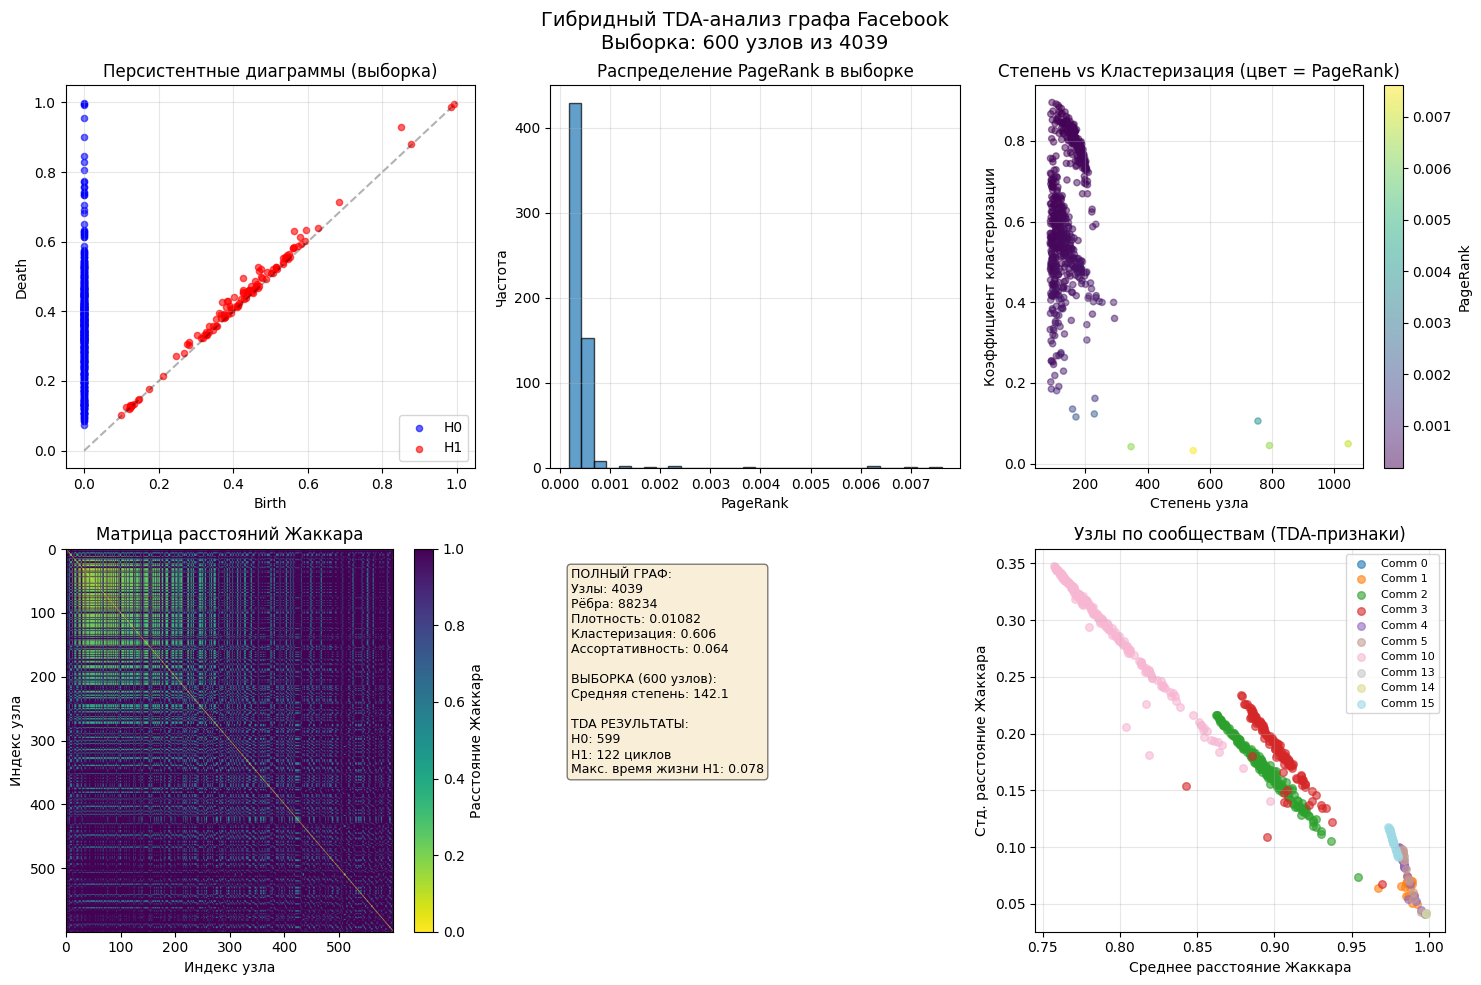


ОБОГАЩЕНИЕ EGO-NETWORKS ГЛОБАЛЬНЫМИ ПРИЗНАКАМИ


AttributeError: 'numpy.ndarray' object has no attribute 'get'

In [54]:
# 1. Запускаем гибридный TDA-анализ
print("НАЧАЛО ГИБРИДНОГО TDA-АНАЛИЗА")
print("="*60)

# Используем стратегию degree_based для выбора хабов
results = tda_on_sample_with_global_context(
    G_combined, 
    sample_size=600,  
    strategy="degree_based"
)

# 2. Обогащаем ego-networks глобальными признаками
# (предполагаем, что ego_networks уже загружены)
if 'ego_networks' in globals():
    enriched_ego_networks = enrich_ego_networks_with_global_features(
        ego_networks, 
        results['global_features']
    )
    
    print("\n" + "="*60)
    print("РЕЗУЛЬТАТЫ ДЛЯ ИСПОЛЬЗОВАНИЯ В GNN:")
    print("="*60)
    
    # Пример признаков для первого ego-network
    first_ego = list(enriched_ego_networks.keys())[0]
    sample_node = list(enriched_ego_networks[first_ego]['enriched_node_features'].keys())[0]
    
    print(f"\nПример обогащённых признаков узла {sample_node} в ego-{first_ego}:")
    features = enriched_ego_networks[first_ego]['enriched_node_features'][sample_node]
    for key, value in list(features.items())[:8]:
        print(f"  {key}: {value:.6f}")
    
    print(f"\nВсего признаков на узел: {len(features)}")
    
# 3. Ключевые выводы для проекта
print("\n" + "="*60)
print("КЛЮЧЕВЫЕ ВЫВОДЫ ДЛЯ ПРОЕКТА GEOMETRIC ML:")
print("="*60)

# Сравнение prior'ов
print(f"\n1. Сравнение prior'ов на разных масштабах:")
print(f"   Локально (ego-nets): отрицательная ассортативность")
print(f"   Глобально: assortativity = {results['global_features']['degree_assortativity']:.3f}")

# TDA результаты
if results['persistence_by_dim'].get(1):
    h1_points = results['persistence_by_dim'][1]
    lifetimes = [d - b for b, d in h1_points]
    print(f"\n2. Топологический анализ (выборка {len(results['sampled_nodes'])} узлов):")
    print(f"   Найдено H1 циклов: {len(h1_points)}")
    print(f"   Максимальное время жизни: {np.max(lifetimes):.3f}")
    print(f"   Устойчивые циклы (>0.1): {sum(1 for lt in lifetimes if lt > 0.1)}")

# Практические рекомендации для GNN
print(f"\n3. Рекомендации для GNN-архитектуры:")
print(f"   - Использовать global_pagerank как weight в message passing")
print(f"   - Добавить global_community_id как категориальный признак")
print(f"   - Учесть anti-assortativity в выборе агрегации")